In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score # 分类报告， roc曲线， auc面积
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('breast-cancer-wisconsin.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
0     699 non-null int64
1     699 non-null int64
2     699 non-null int64
3     699 non-null int64
4     699 non-null int64
5     699 non-null int64
6     699 non-null object
7     699 non-null int64
8     699 non-null int64
9     699 non-null int64
10    699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [4]:
df.describe()

,0,1,2,3,4,5,7,8,9,10
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


将第10列数据   数值为2的结果变为0，  数值为4的结果变为1

In [5]:
# 映射
df[10] = df[10].map({2: 0, 4: 1})

查看出第6列中为什么是object类型

In [6]:
# ? 缺失值   删除   ， 修改替换
df[6].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: 6, dtype: int64

In [7]:
# 将？ 替换为当前数据的众数
df.replace('?', 1, inplace=True)
df[6].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
1      16
9       9
7       8
6       4
Name: 6, dtype: int64

In [8]:
# 转化整数类型
df[6] = df[6].astype(np.int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
0     699 non-null int64
1     699 non-null int64
2     699 non-null int64
3     699 non-null int64
4     699 non-null int64
5     699 non-null int64
6     699 non-null int32
7     699 non-null int64
8     699 non-null int64
9     699 non-null int64
10    699 non-null int64
dtypes: int32(1), int64(10)
memory usage: 57.4 KB


类别不平衡： 样本的分类准确率低  
欠采样、过采样、代价敏感学习

In [9]:
df[10].value_counts()

0    458
1    241
Name: 10, dtype: int64

In [10]:
# 过采样处理   
# 给 df[10]=1 加到 458 ， 相差217
# 获取到所有样本类别为1的数据
df1 = df[df[10]==1]
# df1基础上扩展数据
df1 = df1.sample(n=217) # 217
df1.shape

(217, 11)

In [11]:
# 将df1添加到df中
df = pd.concat([df, df1], axis=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [12]:
df[10].value_counts()

1    458
0    458
Name: 10, dtype: int64

1.特征  1-9     
2.标签  10  
3.特征进行  归一化处理  
4.切分训练集和测试集  7:3  
5.使用逻辑回归进行分类处理，并使用网格搜索交叉验证找到模型的最优参数，使用最优参数，打印测试集得分  
6.使用分类的评估指标展示最终的效果

In [14]:
# 切分特征标签
x = df.iloc[:, 1:10]
y = df.iloc[:, -1:]
x = MinMaxScaler().fit_transform(x)
x[:5]

array([[0.44444444, 0.        , 0.        , 0.        , 0.11111111,
        0.        , 0.22222222, 0.        , 0.        ],
       [0.44444444, 0.33333333, 0.33333333, 0.44444444, 0.66666667,
        1.        , 0.22222222, 0.11111111, 0.        ],
       [0.22222222, 0.        , 0.        , 0.        , 0.11111111,
        0.11111111, 0.22222222, 0.        , 0.        ],
       [0.55555556, 0.77777778, 0.77777778, 0.        , 0.22222222,
        0.33333333, 0.22222222, 0.66666667, 0.        ],
       [0.33333333, 0.        , 0.        , 0.22222222, 0.11111111,
        0.        , 0.22222222, 0.        , 0.        ]])

In [15]:
# 4.切分训练集和测试集  7:3  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
# 5.使用逻辑回归进行分类处理，并使用网格搜索交叉验证找到模型的最优参数，使用最优参数，打印测试集得分 
lr = LogisticRegression()
pg = {'penalty': ['l1', 'l2'], 'C':[10, 5, 2, 1]}
model = GridSearchCV(lr, pg, cv=5)
model.fit(x_train, y_train)
model.best_params_

{'C': 5, 'penalty': 'l2'}

In [16]:
lr = LogisticRegression(C=5, penalty='l2')
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.9745454545454545

模型评估方式

In [17]:
# 模型的预测结果
y_ = lr.predict(x_test)
print('分类报告：\n', classification_report(y_test, y_))

分类报告：
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       137
           1       0.98      0.97      0.97       138

   micro avg       0.97      0.97      0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275



0.9946048873373532

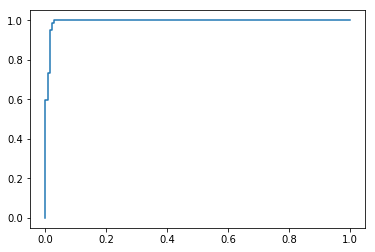

In [20]:
# 二分类可视化评估方式    可视化 roc曲线  数值 auc（roc围成面积）
# 模型预测正类别的概率
y_score = lr.predict_proba(x_test)[:, -1:]
fpr, tpr, _ = roc_curve(y_test, y_score) # fpr，tpr基础的二分类指标
plt.plot(fpr, tpr)
# auc roc下方围成面积
roc_auc_score(y_test, y_score)